# ___

# [ Machine Learning in Geosciences ]

**Department of Applied Geoinformatics and Carthography, Charles University** 

*Lukas Brodsky lukas.brodsky@natur.cuni.cz*

    
___



# Classification Performance Measures

Goal: run classification algorithms and evaluate the models with set of performance measures and interpret the quality.

It covers: 
* training binary classifier and multiclass classification (OvO); 
* choosing appropriate metric for given task; 
* evaluating classifiers using cross-validation (and StratifiedKFOld); 
* selection of precision / recall tradeoff that fits the needs; 
* models comparison using ROC curve (and AUC scores); 

--

* finetune classifier with Grid Search method; 
* data augmentation. 

### Lab setup

In [1]:
# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "/Users/lukasbrodsky/Work/Prfuk/Vyuka/Machine_Learning_in_Geosciences/mlgeo/"
if os.path.isdir(PROJECT_ROOT_DIR):
    print('Ok continue.')
else:
    print('Nok, set correct path to your project directory!')

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

Ok continue.


### MNIST

Use `fetch_openml()` to read MNIST data. MNIST (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that is commonly used for training various image processing systems. 

In [2]:
# function soriting the records
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist_data = mnist.data.to_numpy()
    mnist_target = mnist.target.to_numpy()
    mnist_data[:60000, :] = mnist_data[reorder_train, :]
    mnist_target[:60000] = mnist_target[reorder_train]
    mnist_data[60000:, :] = mnist_data[reorder_test + 60000, :]
    mnist_target[60000:] = mnist_target[reorder_test + 60000]

Warning: download data takes a while! 

In [3]:
# Read data 
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, cache=True)
mnist.target = mnist.target.astype(np.int8) 
# mnist["data"], mnist["target"]

In [4]:
# fetch_openml() returns an unsorted dataset
sort_by_target(mnist) 

In [5]:
mnist.data.shape 

(70000, 784)

In [6]:
type(mnist.data)

pandas.core.frame.DataFrame

In [7]:
# prepare features data and labels 
# X, y = mnist.data, mnist.target
X, y = mnist.data.to_numpy(), mnist.target.to_numpy()
X.shape, y.shape

((70000, 784), (70000,))

In [8]:
# MNIST images dimension
28*28

784

In [9]:
X[36000].shape

(784,)

(-0.5, 27.5, 27.5, -0.5)

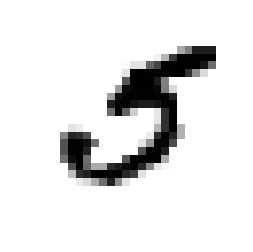

In [10]:
# Check one record
some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = mpl.cm.binary,
           interpolation="nearest")
plt.axis("off")

# save_fig("some_digit_plot")
# plt.show()

In [ ]:
# Which number is it? 

In [11]:
# check the corresponding label
y[36000]

5

In [12]:
# plot some digits to see the data set visualy
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [13]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

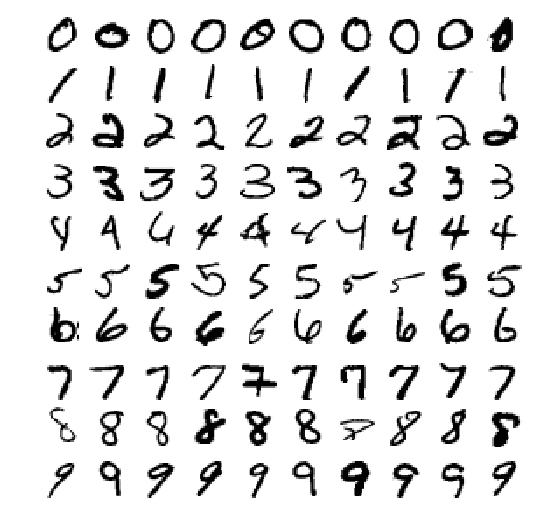

In [14]:
# Plot all figures 
plt.figure(figsize=(9,9))
example_images = np.r_[X[:12000:600], X[13000:30600:600], X[30600:60000:590]]
plot_digits(example_images, images_per_row=10)
# save_fig("more_digits_plot")
# plt.show()

In [15]:
# Split train and test data sets of X and y
import numpy as np

# thr = 60000
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

shuffle_index = np.random.permutation(60000)
print(shuffle_index)

X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

[12628 37730 39991 ...   860 15795 56422]


# Binary classifier

In [ ]:
# Start classification exercize with binary classifier
# Develop model that detects only images with number 5 

In [16]:
# Creat a mask for number 5 
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [17]:
y_test_5

array([False, False, False, ..., False, False, False])

In [18]:
# Use simple Linear model classifier 
# Train it with Stochastic Gradient Descent (SGD) 
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=6, tol=-np.infty, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(max_iter=6, random_state=42, tol=-inf)

In [19]:
# Check prediction on sample 
sgd_clf.predict([some_digit])

array([ True])

In [32]:
# Cross-validate the model with accuracy scoring, e.g. cv=3 
# sklearn.model_selection.cross_val_score(estimator, X, y=None, scoring=None, cv=None, 
# n_jobs=None, verbose=0, fit_params=None, pre_dispatch='2*n_jobs')


from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

# score(X, y[, sample_weight]) .. return the mean accuracy on the given data and labels. 

# Update example! 
# For int/None inputs, if the estimator is a classifier and y is either binary or multiclass, StratifiedKFold is used. 
# In all other cases, KFold is used.

array([0.9471, 0.9384, 0.9672])

In [ ]:
# How good is the model? 

In [33]:
# Run stratified sampling at each run 
# Write the process explicitly 

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

# set number of splits (folds), e.g. 3
n_splits = 3
skfolds = StratifiedKFold(n_splits=n_splits)

sgd_clf_ = SGDClassifier(max_iter=6, tol=-np.infty, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf_)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    # accuracy assesment
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9471
0.9384
0.9672


In [ ]:
# What is the model performance? 

In [ ]:
# Think of the classification problem set up! 

In [34]:
# Create a dummy classifier that returns always zero! 
# Why? 

from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [35]:
Never5Classifier()

Never5Classifier()

In [36]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.909  , 0.90715, 0.9128 ])

In [37]:
# Create a dummy classifier that returns always one! 
# Why? 
from sklearn.base import BaseEstimator
class Always5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.ones((len(X), 1), dtype=bool)

In [38]:
always_5_clf = Always5Classifier()
cross_val_score(always_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.091  , 0.09285, 0.0872 ])

In [ ]:
# What is the accuracy? 
# How good is the model? 
# Why? 

### Confusion Matrix

In [39]:
# Run model prediction with cross-validation (e.g. cv=3)
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [40]:
# print confusion matrix 

from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[52404,  2175],
       [  771,  4650]])

In [ ]:
# How good is the model? 

### Precision & Recall 

In [41]:
# Use sklearn precision and recall methods 
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.6813186813186813

In [ ]:
# Check 
# Precision = TP / (TP + FP)

In [42]:
recall_score(y_train_5, y_train_pred)

0.8577753182069728

In [ ]:
# Check 
# Recall = TP / (TP + FN) 

### F1 score

In [43]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7594316511513963

In [ ]:
# Check 
# F1 = TP / (TP + ((FN + FN) / 2)

### Precision & Recall Tradeoff
Plot the precision - recall function for selected 'some_digit'

In [44]:
# Run cross validation with method="decision_function"  to get scores 
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")
# Predict confidence scores for samples.

In [45]:
y_scores[36000]


-246929.74880149186

In [46]:
# Prepare precision / recall scores for the plot 
# Compute precision-recall pairs for different probability thresholds.
# Note: this implementation is restricted to the binary classification task.

# sklearn.metrics.precision_recall_curve(y_true, probas_pred, *, pos_label=None, sample_weight=None)

from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [ ]:
# thresholds .. increasing thresholds on the decision function used to compute precision and recall. 

In [47]:
print(np.min(thresholds))
print(np.max(thresholds))

-1475798.831245773
910028.4784728297


(-700000, 700000)

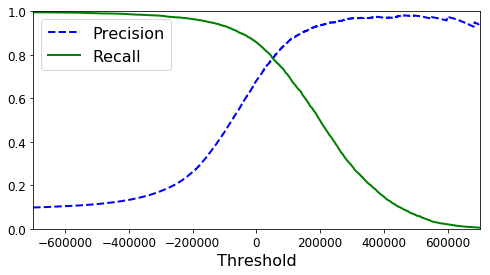

In [48]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-700000, 700000])
# save_fig("precision_recall_vs_threshold_plot")
# plt.show() 

(-150000, 150000)

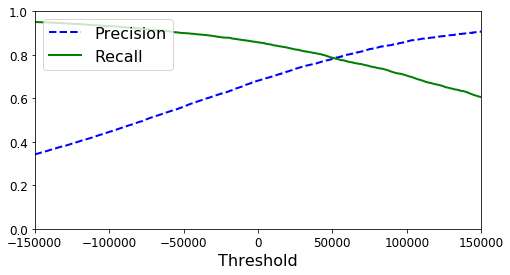

In [49]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-150000, 150000])

In [50]:
# Goal: model with 90% precision 
# thr ~ 150 000
y_train_pred_90 = (y_scores > 150000)

In [51]:
precision_score(y_train_5, y_train_pred_90)

0.90715667311412

In [52]:
recall_score(y_train_5, y_train_pred_90)

0.6056078214351596

In [53]:
# Find a point where precision equals the recall and set the Threshold 
# and re-compute performance measures 

eq = np.where(np.abs(precisions - recalls == np.min(np.abs(precisions - recalls))))[0][0]

y_train_pr = (y_scores >= eq) 
print(precision_score(y_train_5, y_train_pr)) 
print(recall_score(y_train_5, y_train_pr)) 

0.7896803140773977
0.7791920309905921


# ROC curves

In [54]:
# Plot ROC and compare Linear - SGD model with Random Forest 

from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

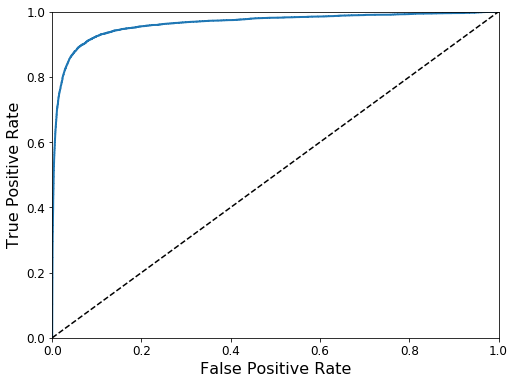

In [55]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
# save_fig("roc_curve_plot")
# plt.show()

In [56]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9637064931685718

### RandomForestClassifier

**Note**: we set `n_estimators=10` to avoid a warning about the fact that its default value will be set to 100.

In [57]:
# takes while 
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=10, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [58]:
# score = probability of positive class
y_scores_forest = y_probas_forest[:, 1]  
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)


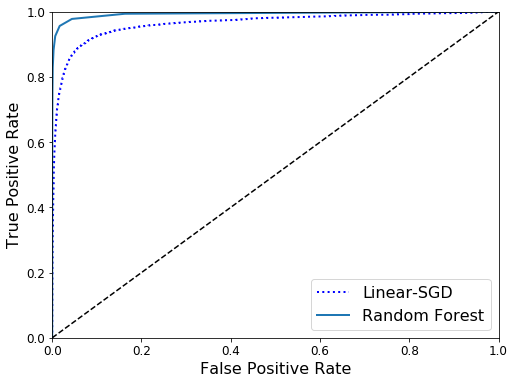

In [59]:
# Compare Linear (SGD)  model with RF 
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="Linear-SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right", fontsize=16)
# save_fig("roc_curve_comparison_plot")
# plt.show()

In [60]:
roc_auc_score(y_train_5, y_scores_forest)

0.9931243366003829

In [ ]:
# RandomForest: F1, Precision & Recall 
...

-------------------------------------------

# Multiclass classification

### One-vs-one multiclass strategy

In [61]:
# Use "One-vs-one multiclass strategy"
# This strategy consists in fitting one classifier per class pair. 
# At prediction time, the class which received the most votes is selected. 
# Since it requires to fit n_classes * (n_classes - 1) / 2 classifiers, this method is usually slower 
# than one-vs-the-rest, due to its O(n_classes^2) complexity.

# However, this method may be advantageous for algorithms such as kernel algorithms which 
# don’t scale well with n_samples. This is because each individual learning problem only involves 
# a small subset of the data whereas, with one-vs-the-rest, the complete dataset is used n_classes times.

from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(max_iter=5, tol=-np.infty, random_state=42))
ovo_clf.fit(X_train, y_train)
# check 5
ovo_clf.predict([some_digit])

array([5], dtype=int8)

In [62]:
len(ovo_clf.estimators_)

45

In [63]:
y_test_ovo_pred = ovo_clf.predict(X_test)

In [64]:
print(precision_score(y_test, y_test_ovo_pred, average='weighted')) 
print(recall_score(y_test, y_test_ovo_pred, average='weighted'))
print(f1_score(y_test, y_test_ovo_pred, average='weighted'))

0.9229756807028223
0.9209
0.9212220545171133


In [79]:
# OnevsOne 
# OnevsMany
# Sklearn detects authomatically binary classifier and sets for OvA or OvO in case of RF. 

### Random Forest

In [65]:
# Random forest clasifier 
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5], dtype=int8)

In [ ]:
# forest_clf.predict_proba([some_digit])

In [66]:
# cross-validating RF takes while 
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.8536, 0.8572, 0.8714])

In [67]:
# Try Standard Scaler on input featuers 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.91135, 0.91005, 0.9073 ])

In [ ]:
# TODO: calculate F1, precision, recall 

In [68]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5737,    2,   21,    8,   10,   44,   49,    9,   40,    3],
       [   2, 6488,   46,   26,    6,   36,    5,    9,  112,   12],
       [  57,   38, 5337,   97,   84,   25,   86,   57,  160,   17],
       [  52,   43,  129, 5349,    1,  226,   34,   54,  139,  104],
       [  21,   28,   40,   11, 5335,    9,   62,   31,   78,  227],
       [  71,   45,   31,  191,   60, 4596,  115,   32,  179,  101],
       [  36,   25,   44,    2,   44,   87, 5626,    7,   47,    0],
       [  24,   22,   70,   28,   49,   12,    5, 5818,   14,  223],
       [  58,  159,   63,  158,   10,  157,   62,   21, 5014,  149],
       [  41,   33,   30,   84,  154,   32,    2,  226,   73, 5274]])

In [69]:
def plot_confusion_matrix(matrix):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

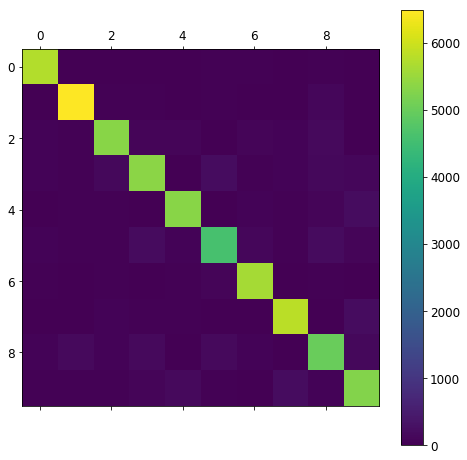

In [70]:
plot_confusion_matrix(conf_mx)

In [ ]:
# Perferct fit? 

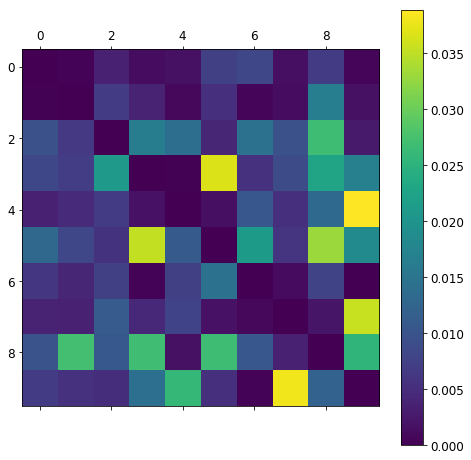

In [71]:
# Plot normalized confusion matrix 
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)

# plt.matshow(norm_conf_mx, cmap=plt.cm.blues)
plot_confusion_matrix(norm_conf_mx)
# save_fig("confusion_matrix_errors_plot", tight_layout=False)
# plt.show()

## Exercise: run Grid Search to finetune the hyperparameters 

In [72]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# set "uniform", "distance" weights 
# set n neigbours to 3, 4, 5
param_grid = [{'weights': ["uniform", "distance"], 'n_neighbors': [3, 4, 5]}]

# use KNC classifier for simplicity and performance
knn_clf = KNeighborsClassifier()

In [73]:
# Run grid search COMPUTATIONALLY DEMANDING (30+ min.)! 

# set cv to 3
# verbose=3 
# 3 : the fold and candidate parameter indexes are also displayed together with the starting time of the computation.
# n_jobs= (N_cores - 1) 

grid_search = GridSearchCV(knn_clf, param_grid, cv=3, verbose=3, n_jobs=1)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV 1/3] END .................n_neighbors=3, weights=uniform; total time= 1.9min
[CV 2/3] END .................n_neighbors=3, weights=uniform; total time= 1.7min
[CV 3/3] END .................n_neighbors=3, weights=uniform; total time= 1.9min
[CV 1/3] END ................n_neighbors=3, weights=distance; total time= 1.9min
[CV 2/3] END ................n_neighbors=3, weights=distance; total time= 1.6min
[CV 3/3] END ................n_neighbors=3, weights=distance; total time= 1.7min
[CV 1/3] END .................n_neighbors=4, weights=uniform; total time= 1.6min
[CV 2/3] END .................n_neighbors=4, weights=uniform; total time= 1.5min
[CV 3/3] END .................n_neighbors=4, weights=uniform; total time= 1.3min
[CV 1/3] END ................n_neighbors=4, weights=distance; total time=  58.0s
[CV 2/3] END ................n_neighbors=4, weights=distance; total time= 1.1min
[CV 3/3] END ................n_neighbors=4, weigh

GridSearchCV(cv=3, estimator=KNeighborsClassifier(), n_jobs=1,
             param_grid=[{'n_neighbors': [3, 4, 5],
                          'weights': ['uniform', 'distance']}],
             verbose=3)

In [74]:
grid_search.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [75]:
grid_search.best_score_

0.9718166666666667

In [76]:
from sklearn.metrics import accuracy_score

y_pred = grid_search.predict(X_test)
print(accuracy_score(y_test, y_pred)) 

print(precision_score(y_test, y_pred, average='weighted')) 
print(recall_score(y_test, y_pred, average='weighted'))
print(f1_score(y_test, y_pred, average='weighted'))

0.9714
0.9715166824529755
0.9714
0.9713597782738583


## Data Augmentation

In [77]:
# The array is shifted using spline interpolation of the requested order. 
# Points outside the boundaries of the input are filled according to the given mode.
from scipy.ndimage.interpolation import shift

In [78]:
def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])

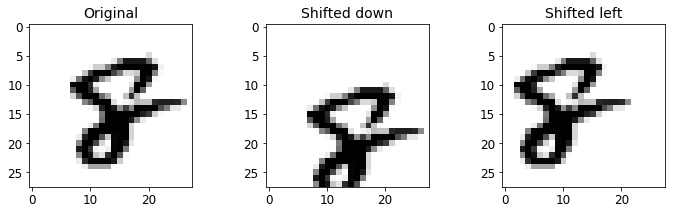

In [79]:
image = X_train[1000]
shifted_image_down = shift_image(image, 0, 5)
shifted_image_left = shift_image(image, -5, 0)

plt.figure(figsize=(12,3))
plt.subplot(131)
plt.title("Original", fontsize=14)
plt.imshow(image.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(132)
plt.title("Shifted down", fontsize=14)
plt.imshow(shifted_image_down.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(133)
plt.title("Shifted left", fontsize=14)
plt.imshow(shifted_image_left.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.show()


In [ ]:
# Augmentation takes while 
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [ ]:
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

In [ ]:
knn_clf = KNeighborsClassifier(**grid_search.best_params_)

In [ ]:
knn_clf.fit(X_train_augmented, y_train_augmented)

In [ ]:
y_pred = knn_clf.predict(X_test)

print(accuracy_score(y_test, y_pred)) x

print(precision_score(y_test, y_pred, average='weighted')) 
print(recall_score(y_test, y_pred, average='weighted'))
print(f1_score(y_test, y_pred, average='weighted'))

In [ ]:
# What is the effect of data augmentnation?